In [2]:
import torch

def check_cuda_availability():
    if torch.cuda.is_available():
        print("CUDA is available.")
        print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Device Count: {torch.cuda.device_count()}")
    else:
        print("CUDA is not available.")

# Call the function
check_cuda_availability()

CUDA is available.
CUDA Device Name: NVIDIA GeForce GTX 1080
CUDA Device Count: 1


In [1]:
import os
os.environ['WANDB_DISABLED'] = 'true'
from ultralytics import YOLO
import cv2
import albumentations as A
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from pathlib import Path
import torchvision.models as models
import random
from collections import Counter
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
print(torch.version.cuda)

None


In [4]:
# 500 Samples. Split is 7(1/3 White BG - 2/3 Environment BG)/2(1/3 White BG - 2/3 Environment BG)/1

def split_dataset(root_dir, output_dir, train_count=350, val_count=100, test_count=50):
    total_count = train_count + val_count + test_count
    train_white_bg_count = train_count // 3
    train_env_bg_count = train_count - train_white_bg_count
    val_white_bg_count = val_count // 3
    val_env_bg_count = val_count - val_white_bg_count

    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        
        # Process White BG images for the training and validation sets
        white_bg_path = os.path.join(class_path, 'White BG')
        white_bg_images = []
        if os.path.exists(white_bg_path):
            white_bg_images = [f for f in os.listdir(white_bg_path) if os.path.isfile(os.path.join(white_bg_path, f)) and 'Discard' not in os.path.join(white_bg_path, f)]
            random.shuffle(white_bg_images)
            white_bg_train_images = white_bg_images[:train_white_bg_count]
            white_bg_val_images = white_bg_images[train_white_bg_count:train_white_bg_count + val_white_bg_count]

        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        for img in white_bg_train_images:
            shutil.copy(os.path.join(white_bg_path, img), os.path.join(train_dir, class_dir, f"white_bg_{img}"))

        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        for img in white_bg_val_images:
            shutil.copy(os.path.join(white_bg_path, img), os.path.join(val_dir, class_dir, f"white_bg_{img}"))

        # Process Environmental images
        env_path = os.path.join(class_path, 'All')
        env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
        random.shuffle(env_images)

        # Ensure we have enough images
        if len(env_images) < (train_env_bg_count + val_env_bg_count + test_count):
            print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
            continue

        test_images = env_images[:test_count]
        val_images = env_images[test_count:test_count + val_env_bg_count]
        train_images = env_images[test_count + val_env_bg_count:test_count + val_env_bg_count + train_env_bg_count]

        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        for img in val_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        for img in train_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

    print("Dataset split completed.")
    return train_dir, val_dir, test_dir, class_dirs


In [5]:
root_dir = r"G:\SNAPFOLIA OJT SY 24 25\Dataset Versions\DATASET_3.2"
output_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG"

In [6]:
# Define the directories where your split data is stored
train_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train"
val_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val"
test_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test"

# Get the class directories from the train directory
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

In [ ]:
train_dir, val_dir, test_dir, class_dirs = split_dataset(root_dir, output_dir)

In [7]:
# Initialize counters
train_counts = Counter()
val_counts = Counter()
test_counts = Counter()

# Calculate counts
for class_dir in class_dirs:
    train_counts[class_dir] = len(os.listdir(os.path.join(train_dir, class_dir)))
    val_counts[class_dir] = len(os.listdir(os.path.join(val_dir, class_dir)))
    test_counts[class_dir] = len(os.listdir(os.path.join(test_dir, class_dir)))

# Save class names in a variable
classes = [class_name for class_name in class_dirs]

# Print the counts
print("\nDataset Labels:")
print({class_name: idx for idx, class_name in enumerate(class_dirs)})

print("\nTotal Images per Class:")
for idx, class_name in enumerate(class_dirs):
    total = train_counts[class_name] + val_counts[class_name] + test_counts[class_name]
    print(f"{idx}    {class_name}: {total}")

print("\nImages per Class in TRAIN:")
for idx, (class_name, count) in enumerate(train_counts.items()):
    print(f"{idx}    {class_name}: {count}")

print("\nImages per Class in VALIDATION:")
for idx, (class_name, count) in enumerate(val_counts.items()):
    print(f"{idx}    {class_name}: {count}")

print("\nImages per Class in TEST:")
for idx, (class_name, count) in enumerate(test_counts.items()):
    print(f"{idx}    {class_name}: {count}")


Dataset Labels:
{'Acacia': 0, 'Alibangbang': 1, 'Amugis': 2, 'Apitong': 3, 'Asis': 4, 'Balayong': 5, 'Balete': 6, 'Banaba': 7, 'Bani': 8, 'Barako': 9, 'Bayabas': 10, 'Betis': 11, 'Binunga': 12, 'Dao': 13, 'Dita': 14, 'Duhat': 15, 'Eucalyptus': 16, 'Guyabano': 17, 'Hinadyong': 18, 'Ilang Ilang': 19, 'Ipil': 20, 'Kalios': 21, 'Kamagong': 22, 'Langka': 23, 'Lansones': 24, 'Madre Cacao': 25, 'Mahogany': 26, 'Mangga': 27, 'Mulawin': 28, 'Narra': 29, 'Native Talisay': 30, 'Palo Maria': 31, 'Scramble Egg': 32, 'Sintores': 33, 'Tibig': 34, 'Yakal': 35}

Total Images per Class:
0    Acacia: 679
1    Alibangbang: 500
2    Amugis: 500
3    Apitong: 500
4    Asis: 500
5    Balayong: 500
6    Balete: 500
7    Banaba: 500
8    Bani: 500
9    Barako: 500
10    Bayabas: 500
11    Betis: 500
12    Binunga: 500
13    Dao: 500
14    Dita: 500
15    Duhat: 500
16    Eucalyptus: 500
17    Guyabano: 500
18    Hinadyong: 497
19    Ilang Ilang: 500
20    Ipil: 500
21    Kalios: 497
22    Kamagong: 500
23    

In [8]:
def get_classes_from_directory(directory):
    return sorted([d.name for d in os.scandir(directory) if d.is_dir()])

def print_number_of_classes(directory):
    classes = get_classes_from_directory(directory)
    print(f"Number of classes: {len(classes)}")
    print(f"Classes: {classes}")
    
# Print the number of classes
print_number_of_classes(train_dir)

Number of classes: 36
Classes: ['Acacia', 'Alibangbang', 'Amugis', 'Apitong', 'Asis', 'Balayong', 'Balete', 'Banaba', 'Bani', 'Barako', 'Bayabas', 'Betis', 'Binunga', 'Dao', 'Dita', 'Duhat', 'Eucalyptus', 'Guyabano', 'Hinadyong', 'Ilang Ilang', 'Ipil', 'Kalios', 'Kamagong', 'Langka', 'Lansones', 'Madre Cacao', 'Mahogany', 'Mangga', 'Mulawin', 'Narra', 'Native Talisay', 'Palo Maria', 'Scramble Egg', 'Sintores', 'Tibig', 'Yakal']


In [18]:
model_path = 'yolov8n-cls.pt'

def load_model_on_cuda(model_path):
    # Load the model
    model = YOLO(model_path)
    
    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model.to(device)
        print(f"Model moved to {device}")
    else:
        device = torch.device('cpu')
        print(f"CUDA not available, using {device}")

    return model

model = load_model_on_cuda(model_path)

Model moved to cuda


In [ ]:
model.train(data='C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG', epochs=20, imgsz=640)

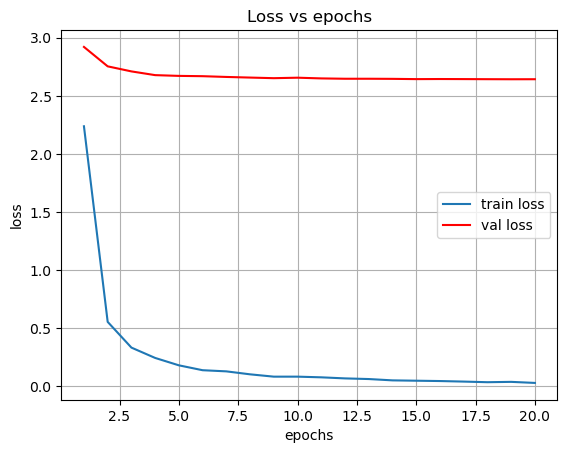

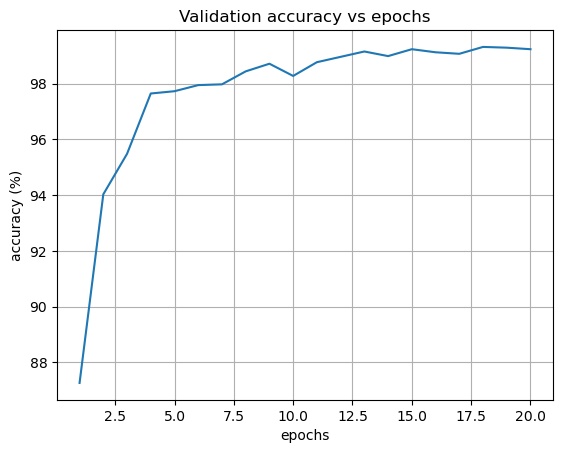

In [9]:
results_path = './runs/classify/train5/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [10]:
def generate_classification_report(run_dir, data_dir, classes):
    # Load the model
    model = YOLO(f'{run_dir}/weights/best.pt')
    
    # Prepare the test dataset
    test_dir = os.path.join(data_dir, 'test')
    test_images = []
    test_labels = []
    for class_id, class_name in enumerate(classes):
        class_dir = os.path.join(test_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            test_images.append(image_path)
            test_labels.append(class_id)
    
    # Predict and collect results
    y_true = []
    y_pred = []
    for image_path, label in zip(test_images, test_labels):
        predict = model(image_path)
        probs = predict[0].probs.data.tolist()
        predicted_class = np.argmax(probs)
        
        y_true.append(label)
        y_pred.append(predicted_class)
    
    # Debugging output
    print(f"Unique classes in y_true: {np.unique(y_true)}")
    print(f"Unique classes in y_pred: {np.unique(y_pred)}")
    
    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print(report)

    return y_true, y_pred


In [ ]:
def generate_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
# Generate classification report and confusion matrix
y_true, y_pred = generate_classification_report('runs/classify/train5', r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG", classes)
generate_confusion_matrix(y_true, y_pred, classes)